In [1]:
import ads
token='zHhOeWHFygdKkb9wGAbOAwwPrqDC4U95gllEtmvq'

In [2]:
import os
import datetime as dt
import pandas as pd


def query_counts(name, query, year, acknowledgements=False):
    if acknowledgements:
        query = 'ack:' + query
    modifiers = ' '.join([f'year:{year}'])
    full_query = ' '.join([query, modifiers])
    filter_query = ['database:astronomy',
                    'property:refereed']
    papers = ads.SearchQuery(q=full_query, fq=filter_query, token=token)
    papers.execute()
    count = int(papers.response.numFound)
    total_papers = ads.SearchQuery(q=modifiers, token=token)
    total_papers.execute()
    total_count = int(total_papers.response.numFound)
    now = dt.datetime.now().timetuple()
    if year == now.tm_year:
        days_in_year = dt.date(year, 12, 31).timetuple().tm_yday
        count *= days_in_year / now.tm_yday
        total_count *= days_in_year / now.tm_yday
    return dict(name=name, query=query, year=year, count=count,
                total_count=total_count)


languages = {
                'IDL': ['IDL'],
                'Python': ['Python'],
                'Matlab': ['MATLAB', 'Matlab'],
                'Fortran': ['Fortran', 'FORTRAN'],
                'Java': ['Java'],
                'C': ['C programming language', 'C language', 'C code',
                    'C library', 'C module'],
                'R': ['R programming language', 'R language', 'R code',
                    'R library', 'R module'],
                'Mathematica': ['Mathematica'],
                'Julia': ['Julia'],
            }

filename = 'ADS_results.csv'

if not os.path.exists(filename):
    results = pd.DataFrame([query_counts(name, query, year)
                            for name, queries in languages.items()
                            for query in queries
                            for year in range(1995, 2020)])
    results.to_csv(filename, index=False)

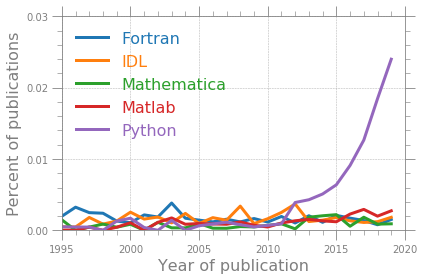

In [13]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

results = pd.read_csv("ADS_results.csv")
results = results.groupby(['name', 'year']).sum().reset_index()
results['pct'] = 100 * results['count'] / results['total_count']

matplotlib.rc('axes', edgecolor='C7')
fig, ax = plt.subplots()

for name, group in results.groupby('name'):
    if name in ['R', 'C', 'Java', 'Julia']:
        continue
    group.plot.line(x='year', y='pct', ax=ax, label=name, linewidth=3)

ax.set(xlabel='Year of Publication',
        ylabel='Percent of Publications')

# text annotations
leg = plt.legend(loc=2, fontsize=16)
leg.get_frame().set_alpha(0)
for i, text in enumerate(leg.get_texts()):
    text.set_color("C" + str(i))
plt.xlabel("Year of publication", color="C7", size=16)
plt.ylabel("Percent of publications", color="C7", size=16)

# final layout options
plt.xticks(np.arange(1995, 2025, 5), color="C7")
plt.yticks(np.arange(0.0, 0.05, 0.01), color="C7")
plt.gca().set_xticks(np.arange(1995, 2020, 1), minor=True)
plt.gca().set_yticks(np.arange(0.0, 0.05, 0.002), minor=True)
plt.tick_params(which='minor', length=5, color="C7")
plt.tick_params(which='major', length=10, color="C7")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().yaxis.set_ticks_position("both")
plt.grid(linestyle="dashed", linewidth=0.5)
plt.ylim(0.00, 0.03)
plt.tight_layout()
fig.savefig('ads-languages.png', transparent=True, dpi=300)